### A pyiron workflow to calculate a grain boundary energy using multiple potentials, and compare to literature DFT data.

This notebook __doesn't__ work out of the box if you haven't configured LAMMPS for pyiron

conda install -c conda-forge lammps 

OR

mamba install -c conda-forge lammps

In the python environment in which you are running pyiron

WARNING: In practice/production you should configure a compiled LAMMPS executable that is optimised for your cluster!

In [1]:
from pyiron.project import Project
from pyiron.atomistics.structure.atoms import ase_to_pyiron, pymatgen_to_pyiron

import numpy as np
import pandas as pd
import shutil

from ase.lattice.cubic import BodyCenteredCubic as bcc
from ase.build import stack

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.core import Structure

import matplotlib.pyplot as plt

In [2]:
def add_vacuum(structure, vacuum):
    """
    Adds padding to a slab or 2D material.

    Args:
        structure (Structure): Structure to add vacuum to
        vacuum (float): Vacuum thickness to add in Angstroms
    Returns:
        Structure object with vacuum added.
    """
    struct = structure.copy()
    coords = [s.coords for s in struct.sites]
    species = [s.specie for s in struct.sites]
    lattice = struct.lattice.matrix
    lattice.setflags(write=1)
    lattice_C = lattice
    lattice_C[2][2] += vacuum
    struct = Structure(lattice_C, species, coords, coords_are_cartesian=True)
    struct.translate_sites(range(len(struct)), [0,0,vacuum/2], frac_coords=False)
    return struct

In [3]:
pr = Project("GB_calcs")

Create the structure that we're going to use:
a $\Sigma 3 [1 \bar{1}0](111)$ Fe GB

In [4]:
surface1 = [1, 1, 1]
surface2 = [1, 1, -1]
rotation_axis = [1, -1, 0]
element = "Fe"
lc = 2.8318488966083
GB_name = "S3-RA110-S1-11"

# The minimum required length of the cell.
req_length = 30

v1 = list(-np.cross(rotation_axis,surface1))
v2 = list(-np.cross(rotation_axis,surface2)) 

length = 0
n = 0
while length < req_length:
    n += 1
    
    slab1 = bcc(symbol=element, latticeconstant=lc,directions=[rotation_axis,v1,surface1], size=[1,1,n])
    slab2 = bcc(symbol=element, latticeconstant=lc,directions=[rotation_axis,v2,surface2], size=[1,1,n])

    gb = stack(slab1, slab2)
    slab = stack(slab1, slab1)
    length = gb.cell[-1,-1]
    
    # Rattle the gb structure using rattle in ASE to perturb symmetry
    gb.rattle()
    slab.rattle()
    
    slab_pmg = add_vacuum(AseAtomsAdaptor().get_structure(slab).copy(), 10)
    gb_pmg = add_vacuum(AseAtomsAdaptor().get_structure(gb).copy(), 10)

gb_pmg.sort(lambda x: x.frac_coords[-1])
slab_pmg.sort(lambda x: x.frac_coords[-1])

For the purposes of segregation, we need to create a set of GBs with a segregant (here it is P) substituted at various sites near the GB.

Create the slab structure for a reference, in this case subsitute 1 P atom in to the slab bcc cell for a reference chemical potential 

In [5]:
slab_pmg_P = slab_pmg.copy()
slab_pmg_P[40] = "P"

In [6]:
mid_point = gb_pmg.lattice.c / 2
mid_point

22.16717158899204

In [7]:
# We just need to set some arbitrary threshold past which we don't compute the segregation energy of that site
# In practice, it is safe to set this to be less than 6 angstrom away from the GB
threshold = 6
structure_list = []
structure_name_list = []
structure_dist_list = []
for i, site in enumerate(gb_pmg):
    GB_seg_struct = gb_pmg.copy()
    dist_GB = abs(site.coords[-1] - mid_point)
    if dist_GB < 6:
        GB_seg_struct[i] = "P"
        structure_name_list.append(f"GB_P_%s_d_%.2f" % (int(i), dist_GB))
        structure_list.append(GB_seg_struct)
        structure_dist_list.append(dist_GB)

Create the pyiron job, assign the structure to the job.

In [8]:
job = pr.create_job(job_type=pr.job_type.Lammps, job_name='Fe_S3_GB')

job.structure = pymatgen_to_pyiron(structure_list[0])

We need to see the potentials, pyiron has an inbuilt potential database

It automatically finds the applicable potentials given the structure provided.

In [9]:
job.list_potentials()[:10]

['2004--Ackland-G-J--Fe-P--LAMMPS--ipr1',
 '2012--Ko-W-S--Fe-P--LAMMPS--ipr1',
 'EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005',
 'MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000']

In [10]:
def run_lammps_calc(structure, job_name, potential):
    job = pr.create_job(job_type=pr.job_type.Lammps, job_name=job_name)
    job.structure = structure
    job.potential = potential
    job.calc_minimize(pressure=None,
                        max_iter=10000)
    job.run(delete_existing_job=True)
    return job['output/generic/energy_tot'][-1]

In [11]:
potentials_tested = job.list_potentials()
E_seg_list = []
for j, potential in enumerate(potentials_tested):
    E_seg_list_potential = []
    for i, struct in enumerate(structure_list):
        try:
            if i == 0:
                E_pure_GB = run_lammps_calc(pymatgen_to_pyiron(gb_pmg), f"S3_PureGB_{j}", potential)
                E_pure_SLAB = run_lammps_calc(pymatgen_to_pyiron(slab_pmg), f"S3_PureSLAB_{j}", potential)
                E_SLAB_P = run_lammps_calc(pymatgen_to_pyiron(slab_pmg_P), f"S3_segSLAB_{j}", potential)
            E_GB_P = run_lammps_calc(pymatgen_to_pyiron(struct), f"S3_segGB_{j}_{structure_name_list[i]}", potential)
            # Formula for segregation energy is E_seg = E_seg_GB - E_pure_GB - (E_sol_SLAB - E_pure_SLAB)
            E_seg = E_GB_P - E_pure_GB - (E_SLAB_P - E_pure_SLAB)
            E_seg_list_potential.append(E_seg)
        except:
            E_seg_list_potential.append(np.nan)
    E_seg_list.append(E_seg_list_potential)

The job S3_PureGB_0 was saved and received the ID: 3310
The job S3_PureSLAB_0 was saved and received the ID: 3311
The job S3_segSLAB_0 was saved and received the ID: 3312
The job S3_segGB_0_GB_P_28_d_5d72 was saved and received the ID: 3313
The job S3_segGB_0_GB_P_29_d_5d72 was saved and received the ID: 3314
The job S3_segGB_0_GB_P_30_d_4d91 was saved and received the ID: 3315
The job S3_segGB_0_GB_P_31_d_4d91 was saved and received the ID: 3316
The job S3_segGB_0_GB_P_32_d_4d09 was saved and received the ID: 3317
The job S3_segGB_0_GB_P_33_d_4d09 was saved and received the ID: 3318
The job S3_segGB_0_GB_P_34_d_3d27 was saved and received the ID: 3319
The job S3_segGB_0_GB_P_35_d_3d27 was saved and received the ID: 3320
The job S3_segGB_0_GB_P_36_d_2d45 was saved and received the ID: 3321
The job S3_segGB_0_GB_P_37_d_2d45 was saved and received the ID: 3322
The job S3_segGB_0_GB_P_38_d_1d63 was saved and received the ID: 3323
The job S3_segGB_0_GB_P_39_d_1d63 was saved and received th

2023-09-18 00:51:16,878 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_PureGB_2
2023-09-18 00:51:17,138 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:17,139 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:17,157 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_29_d_5d72


The job S3_PureGB_2 was saved and received the ID: 3376


2023-09-18 00:51:17,434 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:17,436 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:17,453 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_30_d_4d91


The job S3_segGB_2_GB_P_29_d_5d72 was saved and received the ID: 3377


2023-09-18 00:51:17,731 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:17,732 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:17,748 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_31_d_4d91


The job S3_segGB_2_GB_P_30_d_4d91 was saved and received the ID: 3378


2023-09-18 00:51:18,012 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:18,014 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:18,028 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_32_d_4d09


The job S3_segGB_2_GB_P_31_d_4d91 was saved and received the ID: 3379


2023-09-18 00:51:18,273 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:18,274 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:18,291 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_33_d_4d09


The job S3_segGB_2_GB_P_32_d_4d09 was saved and received the ID: 3380


2023-09-18 00:51:18,575 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:18,576 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:18,591 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_34_d_3d27


The job S3_segGB_2_GB_P_33_d_4d09 was saved and received the ID: 3381


2023-09-18 00:51:18,867 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:18,868 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:18,884 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_35_d_3d27


The job S3_segGB_2_GB_P_34_d_3d27 was saved and received the ID: 3382


2023-09-18 00:51:19,136 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:19,137 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:19,153 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_36_d_2d45


The job S3_segGB_2_GB_P_35_d_3d27 was saved and received the ID: 3383


2023-09-18 00:51:19,415 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:19,415 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:19,430 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_37_d_2d45


The job S3_segGB_2_GB_P_36_d_2d45 was saved and received the ID: 3384


2023-09-18 00:51:19,689 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:19,690 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:19,705 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_38_d_1d63


The job S3_segGB_2_GB_P_37_d_2d45 was saved and received the ID: 3385


2023-09-18 00:51:19,957 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:19,958 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:19,975 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_39_d_1d63


The job S3_segGB_2_GB_P_38_d_1d63 was saved and received the ID: 3386


2023-09-18 00:51:20,231 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:20,232 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:20,249 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_40_d_0d82


The job S3_segGB_2_GB_P_39_d_1d63 was saved and received the ID: 3387


2023-09-18 00:51:20,528 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:20,529 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:20,544 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_41_d_0d82


The job S3_segGB_2_GB_P_40_d_0d82 was saved and received the ID: 3388


2023-09-18 00:51:20,808 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:20,809 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:20,827 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_42_d_0d00


The job S3_segGB_2_GB_P_41_d_0d82 was saved and received the ID: 3389


2023-09-18 00:51:21,118 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:21,119 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:21,135 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_43_d_0d00


The job S3_segGB_2_GB_P_42_d_0d00 was saved and received the ID: 3390


2023-09-18 00:51:21,374 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:21,375 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:21,392 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_44_d_0d82


The job S3_segGB_2_GB_P_43_d_0d00 was saved and received the ID: 3391


2023-09-18 00:51:21,664 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:21,665 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:21,681 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_45_d_0d82


The job S3_segGB_2_GB_P_44_d_0d82 was saved and received the ID: 3392


2023-09-18 00:51:21,944 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:21,945 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:21,962 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_46_d_1d63


The job S3_segGB_2_GB_P_45_d_0d82 was saved and received the ID: 3393


2023-09-18 00:51:22,232 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:22,233 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:22,247 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_47_d_1d64


The job S3_segGB_2_GB_P_46_d_1d63 was saved and received the ID: 3394


2023-09-18 00:51:22,490 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:22,491 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.005 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:22,507 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_48_d_2d45


The job S3_segGB_2_GB_P_47_d_1d64 was saved and received the ID: 3395


2023-09-18 00:51:22,793 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:22,794 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:22,812 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_49_d_2d45


The job S3_segGB_2_GB_P_48_d_2d45 was saved and received the ID: 3396


2023-09-18 00:51:23,114 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:23,115 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:23,134 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_50_d_3d27


The job S3_segGB_2_GB_P_49_d_2d45 was saved and received the ID: 3397


2023-09-18 00:51:23,425 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:23,427 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:23,446 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_51_d_3d27


The job S3_segGB_2_GB_P_50_d_3d27 was saved and received the ID: 3398


2023-09-18 00:51:23,749 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:23,751 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:23,771 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_52_d_4d09


The job S3_segGB_2_GB_P_51_d_3d27 was saved and received the ID: 3399


2023-09-18 00:51:24,080 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:24,081 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:24,101 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_53_d_4d09


The job S3_segGB_2_GB_P_52_d_4d09 was saved and received the ID: 3400


2023-09-18 00:51:24,407 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:24,408 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:24,428 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_54_d_4d91


The job S3_segGB_2_GB_P_53_d_4d09 was saved and received the ID: 3401


2023-09-18 00:51:24,736 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:24,737 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:24,756 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_55_d_4d91


The job S3_segGB_2_GB_P_54_d_4d91 was saved and received the ID: 3402


2023-09-18 00:51:25,066 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:25,068 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:25,086 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_56_d_5d72


The job S3_segGB_2_GB_P_55_d_4d91 was saved and received the ID: 3403


2023-09-18 00:51:25,417 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:25,419 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:25,439 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_2_GB_P_57_d_5d72


The job S3_segGB_2_GB_P_56_d_5d72 was saved and received the ID: 3404


2023-09-18 00:51:25,752 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:25,753 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim EAM_Dynamo_AcklandMendelevSrolovitz_2004_FeP__MO_884343146310_005

2023-09-18 00:51:25,772 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_PureGB_3


The job S3_segGB_2_GB_P_57_d_5d72 was saved and received the ID: 3405


2023-09-18 00:51:26,077 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:26,078 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:26,098 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_29_d_5d72


The job S3_PureGB_3 was saved and received the ID: 3406


2023-09-18 00:51:26,400 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:26,401 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:26,421 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_30_d_4d91


The job S3_segGB_3_GB_P_29_d_5d72 was saved and received the ID: 3407


2023-09-18 00:51:26,753 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:26,754 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:26,773 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_31_d_4d91


The job S3_segGB_3_GB_P_30_d_4d91 was saved and received the ID: 3408


2023-09-18 00:51:27,087 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:27,088 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:27,105 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_32_d_4d09


The job S3_segGB_3_GB_P_31_d_4d91 was saved and received the ID: 3409


2023-09-18 00:51:27,409 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:27,410 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:27,426 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_33_d_4d09


The job S3_segGB_3_GB_P_32_d_4d09 was saved and received the ID: 3410


2023-09-18 00:51:27,715 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:27,716 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:27,732 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_34_d_3d27


The job S3_segGB_3_GB_P_33_d_4d09 was saved and received the ID: 3411


2023-09-18 00:51:27,987 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:27,988 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:28,005 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_35_d_3d27


The job S3_segGB_3_GB_P_34_d_3d27 was saved and received the ID: 3412


2023-09-18 00:51:28,270 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:28,271 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:28,287 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_36_d_2d45


The job S3_segGB_3_GB_P_35_d_3d27 was saved and received the ID: 3413


2023-09-18 00:51:28,543 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:28,544 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:28,560 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_37_d_2d45


The job S3_segGB_3_GB_P_36_d_2d45 was saved and received the ID: 3414


2023-09-18 00:51:28,825 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:28,826 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:28,843 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_38_d_1d63


The job S3_segGB_3_GB_P_37_d_2d45 was saved and received the ID: 3415


2023-09-18 00:51:29,116 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:29,118 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:29,133 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_39_d_1d63


The job S3_segGB_3_GB_P_38_d_1d63 was saved and received the ID: 3416


2023-09-18 00:51:29,392 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:29,393 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:29,409 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_40_d_0d82


The job S3_segGB_3_GB_P_39_d_1d63 was saved and received the ID: 3417


2023-09-18 00:51:29,683 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:29,684 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:29,700 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_41_d_0d82


The job S3_segGB_3_GB_P_40_d_0d82 was saved and received the ID: 3418


2023-09-18 00:51:29,964 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:29,965 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:29,983 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_42_d_0d00


The job S3_segGB_3_GB_P_41_d_0d82 was saved and received the ID: 3419


2023-09-18 00:51:30,244 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:30,245 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:30,262 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_43_d_0d00


The job S3_segGB_3_GB_P_42_d_0d00 was saved and received the ID: 3420


2023-09-18 00:51:30,546 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:30,547 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:30,565 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_44_d_0d82


The job S3_segGB_3_GB_P_43_d_0d00 was saved and received the ID: 3421


2023-09-18 00:51:30,802 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:30,804 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:30,820 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_45_d_0d82


The job S3_segGB_3_GB_P_44_d_0d82 was saved and received the ID: 3422


2023-09-18 00:51:31,099 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:31,099 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.004 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:31,116 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_46_d_1d63


The job S3_segGB_3_GB_P_45_d_0d82 was saved and received the ID: 3423


2023-09-18 00:51:31,369 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:31,370 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:31,384 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_47_d_1d64


The job S3_segGB_3_GB_P_46_d_1d63 was saved and received the ID: 3424


2023-09-18 00:51:31,641 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:31,642 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.001 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:31,660 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_48_d_2d45


The job S3_segGB_3_GB_P_47_d_1d64 was saved and received the ID: 3425


2023-09-18 00:51:31,913 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:31,915 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:31,930 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_49_d_2d45


The job S3_segGB_3_GB_P_48_d_2d45 was saved and received the ID: 3426


2023-09-18 00:51:32,180 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:32,181 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:32,196 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_50_d_3d27


The job S3_segGB_3_GB_P_49_d_2d45 was saved and received the ID: 3427


2023-09-18 00:51:32,458 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:32,459 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:32,475 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_51_d_3d27


The job S3_segGB_3_GB_P_50_d_3d27 was saved and received the ID: 3428


2023-09-18 00:51:32,733 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:32,734 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:32,749 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_52_d_4d09


The job S3_segGB_3_GB_P_51_d_3d27 was saved and received the ID: 3429


2023-09-18 00:51:33,012 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:33,013 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:33,029 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_53_d_4d09


The job S3_segGB_3_GB_P_52_d_4d09 was saved and received the ID: 3430


2023-09-18 00:51:33,317 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:33,319 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:33,335 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_54_d_4d91


The job S3_segGB_3_GB_P_53_d_4d09 was saved and received the ID: 3431


2023-09-18 00:51:33,597 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:33,598 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:33,613 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_55_d_4d91


The job S3_segGB_3_GB_P_54_d_4d91 was saved and received the ID: 3432


2023-09-18 00:51:33,861 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:33,863 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:33,878 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_56_d_5d72


The job S3_segGB_3_GB_P_55_d_4d91 was saved and received the ID: 3433


2023-09-18 00:51:34,144 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:34,146 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000

2023-09-18 00:51:34,161 - pyiron_log - WARNING - Job aborted - please remove it and run again! S3_segGB_3_GB_P_57_d_5d72


The job S3_segGB_3_GB_P_56_d_5d72 was saved and received the ID: 3434


2023-09-18 00:51:34,424 - pyiron_log - WARNING - Job aborted
2023-09-18 00:51:34,425 - pyiron_log - WARNING - LAMMPS (23 Jun 2022 - Update 1)
Reading data file ...
  orthogonal box = (0 0 0) to (4.0048391 6.9365848 44.334343)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  84 atoms
  read_data CPU = 0.000 seconds
ERROR: KIM ModelCreate failed (src/KIM/pair_kim.cpp:843)
Last command: pair_style kim MEAM_LAMMPS_KoJimLee_2012_FeP__MO_179420363944_000



The job S3_segGB_3_GB_P_57_d_5d72 was saved and received the ID: 3435


In [12]:
df = pd.DataFrame(np.transpose(E_seg_list), columns=potentials_tested, index=structure_name_list)
df.dropna(axis=1)

,2004--Ackland-G-J--Fe-P--LAMMPS--ipr1,2012--Ko-W-S--Fe-P--LAMMPS--ipr1
GB_P_28_d_5.72,0.003667,-1.107854
GB_P_29_d_5.72,0.003667,-1.107854
GB_P_30_d_4.91,0.009409,0.046456
GB_P_31_d_4.91,0.009409,0.046456
GB_P_32_d_4.09,0.032903,-0.007275
GB_P_33_d_4.09,0.032903,-0.007275
GB_P_34_d_3.27,-1.144830,-1.105626
GB_P_35_d_3.27,-1.144830,-1.105626
GB_P_36_d_2.45,0.180020,0.113790
GB_P_37_d_2.45,0.180020,0.113790


Get the segregation energies from DFT from the literature for verification:

[Mai, H.L., Cui, X.Y., Scheiber, D., Romaner, L. and Ringer, S.P., 2023. Phosphorus and transition metal co-segregation in ferritic iron grain boundaries and its effects on cohesion. Acta Materialia, 250, p.118850.](https://www.sciencedirect.com/science/article/pii/S1359645423001817)


In [13]:
df["DFT"] = [-0.04,
             -0.04,
             0.04,
             0.04,
             -0.02,
             -0.02,
             -0.10,
             -0.10,
             0.10,
             0.10,
             -0.33,
             -0.33,
             -1.15,
             -1.15,
             -0.05,
             -0.05,
             -1.15,
             -1.15,
             -0.33,
             -0.33,
             0.10,
             0.10,
             -0.10,
             -0.10,
             -0.02,
             -0.02,
             0.04,
             0.04,
             -0.04,
             -0.04]

### Plot their segregation profiles wrt. DFT for visualisation and comparison

### Generally the segregation energies at/near the GB are well replicated.

### Notice the large errors are generated by the the potentials further away from the GB - it thinks that there are relaxations where there are none! 

### The sites at the GB are replicated accurately, but the sites further away seem to possess the same energy. This is because of relaxations into the same structure - but DFT does not replicate this phenomena! 

### So there is some kind of fundamental error in the potential's relaxation process.

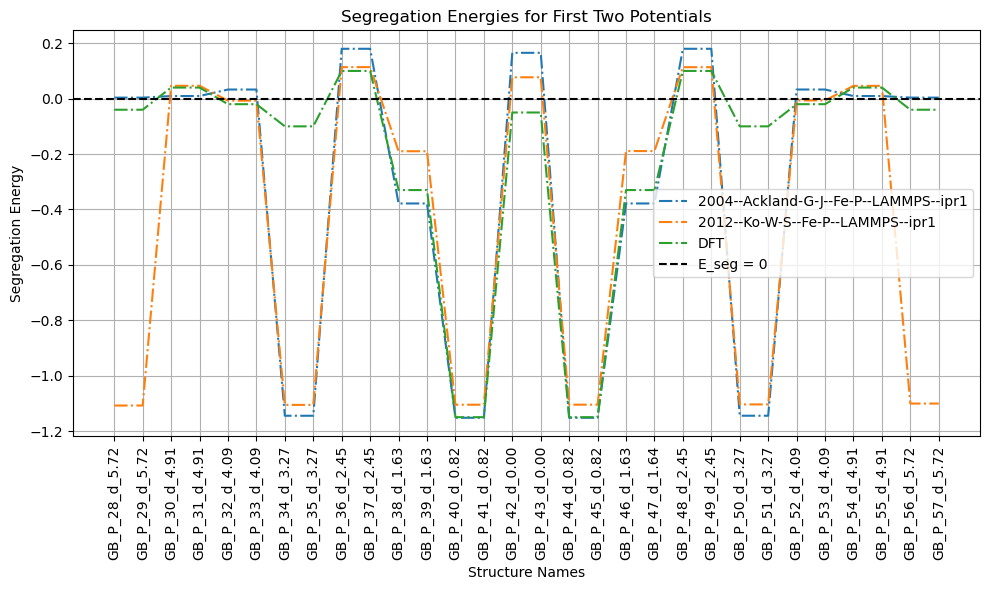

In [14]:
# Extract the data for the first two potentials
potential_1 = df[potentials_tested[0]]
potential_2 = df[potentials_tested[1]]
dft = df["DFT"]
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(potential_1, "-.", label=str(potentials_tested[0]))
plt.plot(potential_2, "-.", label=str(potentials_tested[1]))
plt.plot(dft, "-.", label="DFT")

plt.axhline(y=0, color='black', linestyle='--', label='E_seg = 0')  # Horizontal reference line
plt.xlabel("Structure Names")
plt.ylabel("Segregation Energy")
plt.title("Segregation Energies for First Two Potentials")
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)  # Adding grid lines
plt.tight_layout()
plt.show()


In [16]:
# Optional: Cleanup the dir so we don't have useless huge files
shutil.rmtree("GB_calcs")